In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("classification_train.csv")


In [3]:
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
x_train = df.sample(frac=0.6, random_state=42)
temp_df = df.drop(x_train.index)
x_dev = temp_df.sample(frac=0.5, random_state=42)
x_test = temp_df.drop(x_dev.index)
y_train = x_train.pop("label").values
y_dev = x_dev.pop("label").values
y_test = x_test.pop("label").values

In [5]:
y_test.shape

(6000,)

In [6]:
one_hot_y = pd.get_dummies(y_train)
one_hot_y = one_hot_y.replace({True: 1, False: 0})
one_hot_y = one_hot_y.to_numpy()
one_hot_y = one_hot_y.T

In [7]:
y_train = y_train.reshape(1, -1)
print(y_train.shape)
print(one_hot_y.shape)

(1, 18000)
(10, 18000)


In [8]:
def relu(x):
    return np.maximum(0, x)
    
def derivative_relu(z):
    return np.array(z>0, dtype = 'float')

def softmax(z):
    exp = np.exp(z - np.max(z, axis=0))
    return exp/np.sum(exp, axis=0 ,keepdims = True)

In [9]:
def normal_ele(x):
    meu = np.mean(x, axis = 1)
    max = np.max(x, axis = 1)
    min = np.min(x, axis = 1)
    std = np.std(x, axis = 1)
    meu = meu.to_numpy()
    max = max.to_numpy()
    min = min.to_numpy()
    std = std.to_numpy()
    return meu.reshape(-1,1), max.reshape(-1,1), min.reshape(-1,1), std.reshape(-1,1)
    

In [10]:
def normalise(x, meu, max, min, std):
    epsilon = 10e-8
    n_x = (x-meu)/(std+epsilon)
    return n_x

In [11]:
def inti_weights(layer_dims):
    para = {}
    L = len(layer_dims)-1
    for i in range(1, L+1):
        para["w"+str(i)] = np.random.randn(layer_dims[i], layer_dims[i-1]) * np.sqrt(2. / layer_dims[i - 1])
        para["b"+str(i)] = np.zeros((layer_dims[i], 1))
    return para

In [12]:
def forward_prop(para, x):
    forward_cache = {}
    forward_cache["a0"] = x
    L = (len(para) // 2) 
    for i in range(1, L):
        forward_cache["z" + str(i)] = np.dot(para["w"+str(i)], forward_cache["a"+str(i-1)]) + para["b" + str(i)]
        forward_cache["a" + str(i)] = relu(forward_cache["z" + str(i)])

    forward_cache["z" + str(L)] = np.dot(para["w"+str(L)], forward_cache["a"+str(L-1)]) + para["b" + str(L)]
    forward_cache["a" + str(L)] = softmax(forward_cache["z" + str(L)])
    return forward_cache
        

In [13]:
def back_prop(para, x, y):
    grad = {}
    forward_cache = forward_prop(para, x)
    L = (len(para) // 2)
    m = y.shape[1]
    grad["dz"+str(L)] = forward_cache["a"+str(L)] - y
    grad["dw"+str(L)] = (1./m) * np.dot(grad["dz"+str(L)], forward_cache["a"+str(L-1)].T)
    grad["db"+str(L)] = (1./m) * np.sum(grad["dz"+str(L)], axis=1, keepdims=True)

    for i in reversed(range(1, L)):
        grad["dz"+str(i)] = np.dot(para["w"+str(i+1)].T, grad["dz"+str(i+1)]) * derivative_relu(forward_cache["a"+str(i)])
        grad["dw"+str(i)] = (1./m) * np.dot(grad["dz"+str(i)], forward_cache["a"+str(i-1)].T)
        grad["db"+str(i)] = (1./m) * np.sum(grad["dz"+str(i)], axis=1, keepdims=True)
    return grad

In [14]:
def cost(y, para,x):
    forward_cache = forward_prop(para, x)
    epsilon = 10e-8
    m = y.shape[1]
    L = (len(para)//2)
    cost = -np.sum(y * np.log(forward_cache["a"+str(L)] + epsilon))/m
    return cost

In [15]:
def update_para(para, x, y, alpha):
    L = (len(para) // 2)
    grad = back_prop(para, x, y)
    for i in range(1, L+1):
        para["w"+str(i)] = para["w"+str(i)] - alpha * grad["dw"+str(i)]
        para["b"+str(i)] = para["b"+str(i)] - alpha * grad["db"+str(i)]
    return para

In [16]:
num_iters = 1000
alpha = .03
meu, max, min, std = normal_ele(x_train.T)
n_x_train = normalise(x_train.T, meu, max, min, std)
layer_dims = [x_train.T.shape[0], 16, 32, one_hot_y.shape[0]]
para = inti_weights(layer_dims)
j_his = []

In [17]:
for i in range(num_iters):
    para = update_para(para, n_x_train, one_hot_y, alpha)
    j = cost(one_hot_y, para, n_x_train)
    j_his.append(j)
    if (i % 100 == 0):
        print(f"iteration {i} : cost {j}")

iteration 0 : cost 2.715456583731334
iteration 100 : cost 0.4402418034891021
iteration 200 : cost 0.25880309539990065
iteration 300 : cost 0.19422817858495922
iteration 400 : cost 0.1593580007381264
iteration 500 : cost 0.13706517386964884
iteration 600 : cost 0.12135692805536746
iteration 700 : cost 0.10927303227241277
iteration 800 : cost 0.09969673176769439
iteration 900 : cost 0.09188421292216961


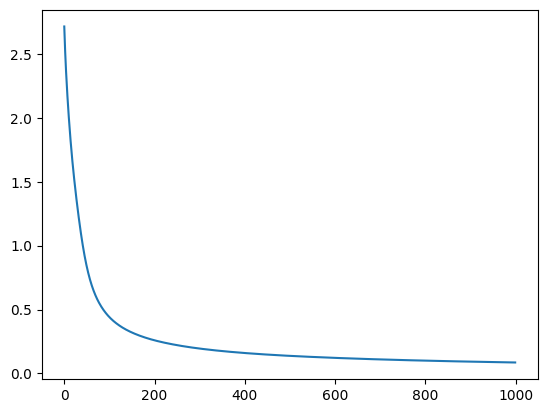

In [18]:
plt.plot(np.arange(num_iters), j_his)

In [19]:
n_x_test = normalise(x_test.T, meu, max, min, std)

In [20]:
n_x_test.shape

(784, 6000)

In [21]:
forward_cache = {}
forward_cache = forward_prop(para, n_x_test)
L = (len(para) // 2)
y_hat = np.argmax(forward_cache["a" + str(L)], axis = 0).reshape(1,-1)
y_test = y_test.reshape(1, -1)
sum = np.sum(y_test == y_hat)

In [22]:
y_hat.shape

(1, 6000)

In [23]:
y_test.shape

(1, 6000)

In [24]:
sum/y_test.shape[1]

0.9606666666666667

In [25]:
x_train.T.shape

(784, 18000)

In [26]:
n_x_train.shape

(784, 18000)

In [27]:
y_test[0, :50]

array([1, 0, 5, 9, 0, 7, 7, 4, 9, 7, 2, 8, 7, 0, 5, 4, 1, 8, 4, 4, 6, 3,
       7, 0, 0, 0, 8, 2, 6, 3, 6, 3, 4, 4, 4, 4, 3, 1, 9, 9, 9, 3, 1, 4,
       6, 4, 2, 7, 9, 7], dtype=int64)

In [28]:
y_hat[0, : 50]

array([1, 0, 5, 9, 0, 7, 7, 4, 9, 7, 2, 8, 7, 0, 5, 4, 1, 8, 4, 4, 6, 3,
       7, 0, 0, 0, 8, 2, 6, 5, 6, 5, 4, 4, 4, 4, 3, 1, 9, 9, 9, 3, 1, 4,
       7, 4, 2, 6, 9, 6], dtype=int64)